## 卷积原理

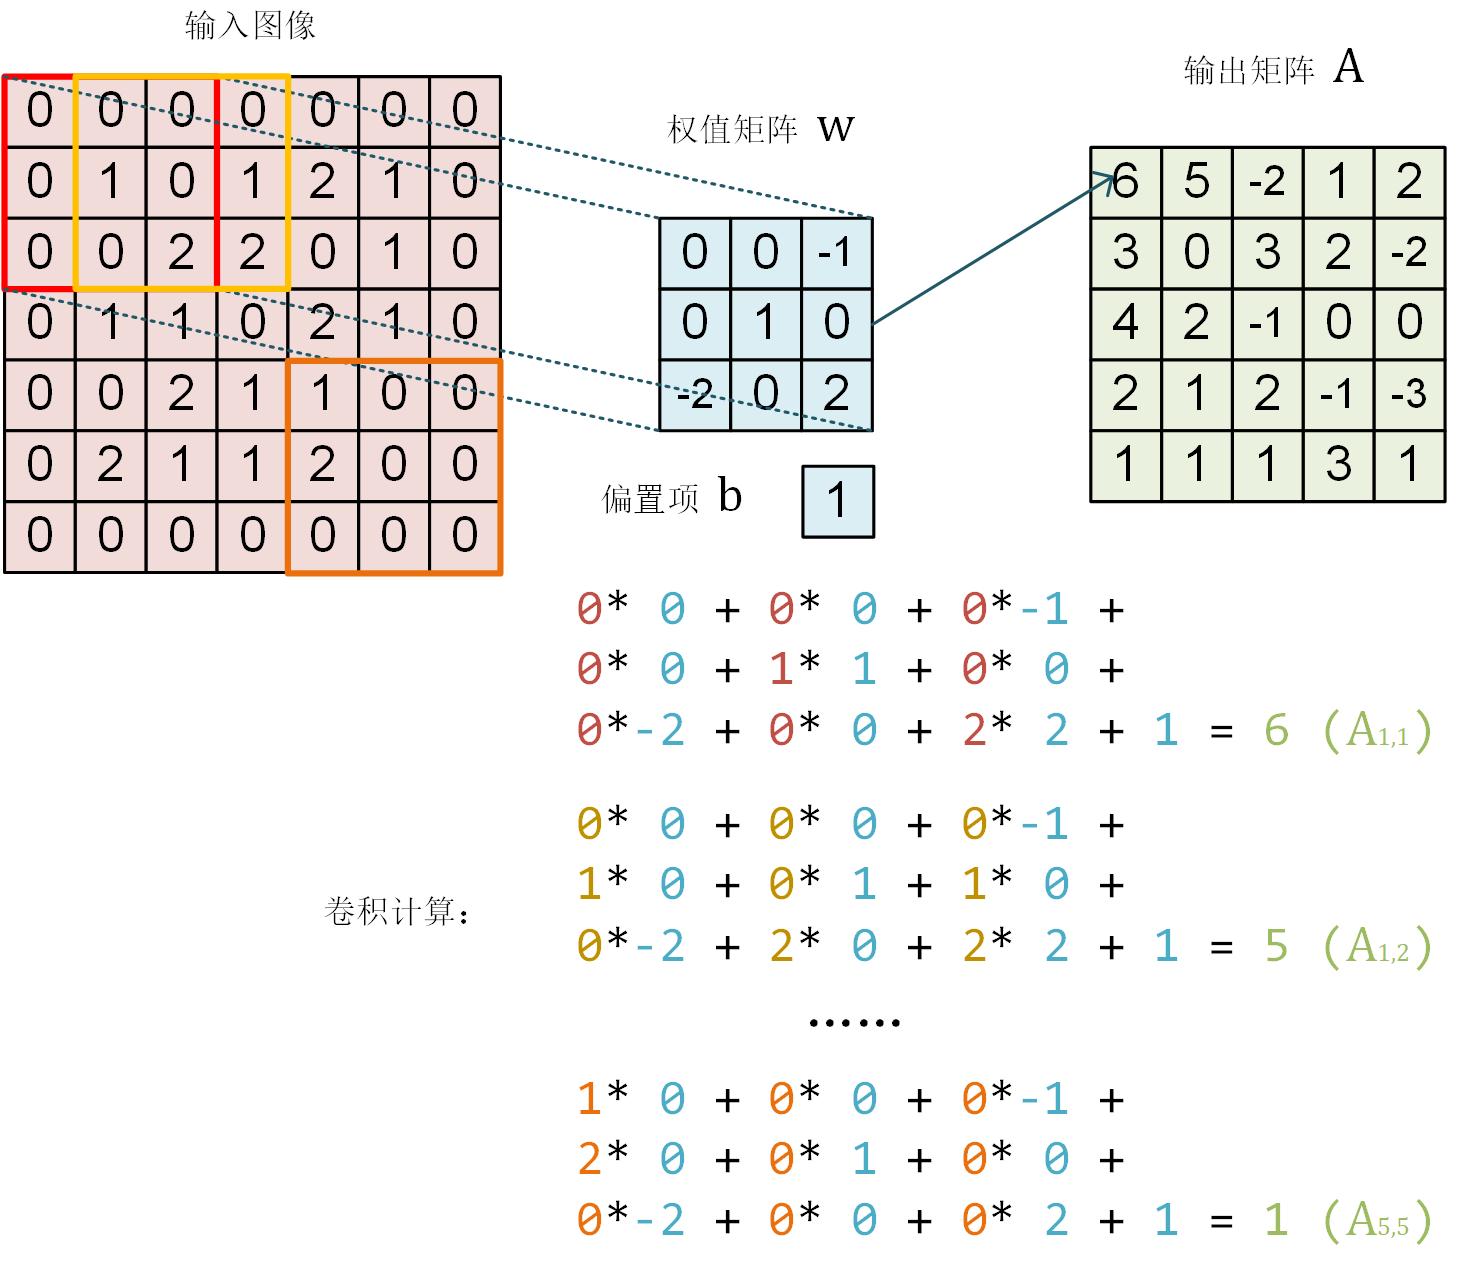

In [44]:
# - 多通道卷积核参数是否一样？
# https://zhuanlan.zhihu.com/p/251068800
# 验证如下：

input_shape = (1, 8, 8, 3)
x = tf.random.normal(input_shape)
layer = tf.keras.layers.Conv2D(
    1, 2, input_shape=input_shape)  # filters： 1， kernel_size: 2
out= layer(x)
layer.trainable_variables
# 打印网络的待优化参数名
i = 0
for p in layer.trainable_variables:
    
    print(p.name, p.shape)
    if i==0:
        print('-'*20)
        print(p.numpy, '\n',tf.reshape(p, [2,2,3]))
    i +=1 

conv2d_41/kernel:0 (2, 2, 3, 1)
--------------------
<bound method BaseResourceVariable.numpy of <tf.Variable 'conv2d_41/kernel:0' shape=(2, 2, 3, 1) dtype=float32, numpy=
array([[[[ 0.3202353 ],
         [-0.4204781 ],
         [ 0.24932194]],

        [[ 0.5717562 ],
         [ 0.1028676 ],
         [-0.22817922]]],


       [[[ 0.38256812],
         [-0.5702144 ],
         [ 0.3493365 ]],

        [[ 0.559048  ],
         [ 0.3836186 ],
         [-0.15904748]]]], dtype=float32)>> 
 tf.Tensor(
[[[ 0.3202353  -0.4204781   0.24932194]
  [ 0.5717562   0.1028676  -0.22817922]]

 [[ 0.38256812 -0.5702144   0.3493365 ]
  [ 0.559048    0.3836186  -0.15904748]]], shape=(2, 2, 3), dtype=float32)
conv2d_41/bias:0 (1,)


In [2]:
import numpy as np
import tensorflow as tf
# TensorFlow 的图像表示为 [图像数目，长，宽，色彩通道数] 的四维张量
# 这里我们的输入图像 image 的张量形状为 [1, 7, 7, 1]
image = np.array([[
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 2, 1, 0],
    [0, 0, 2, 2, 0, 1, 0],
    [0, 1, 1, 0, 2, 1, 0],
    [0, 0, 2, 1, 1, 0, 0],
    [0, 2, 1, 1, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
]], dtype=np.float32)
image = np.expand_dims(image, axis=-1)  

W = np.array([[
    [ 0, 0, -1], 
    [ 0, 1, 0 ], 
    [-2, 0, 2 ]
]], dtype=np.float32)
b = np.array([1], dtype=np.float32)

# 然后建立一个仅有一个卷积层的模型，用 W 和 b 初始化 4 ：

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=1,              # 卷积层神经元（卷积核）数目
        kernel_size=[3, 3],     # 感受野大小
        kernel_initializer=tf.constant_initializer(W),
        bias_initializer=tf.constant_initializer(b)
    )]
)
output = model(image)
tf.squeeze(output)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 6.,  5., -2.,  1.,  2.],
       [ 3.,  0.,  3.,  2., -2.],
       [ 4.,  2., -1.,  0.,  0.],
       [ 2.,  1.,  2., -1., -3.],
       [ 1.,  1.,  1.,  3.,  1.]], dtype=float32)>

可见与上图中矩阵A 中的值一致

## CNN的一个完整示例如下：

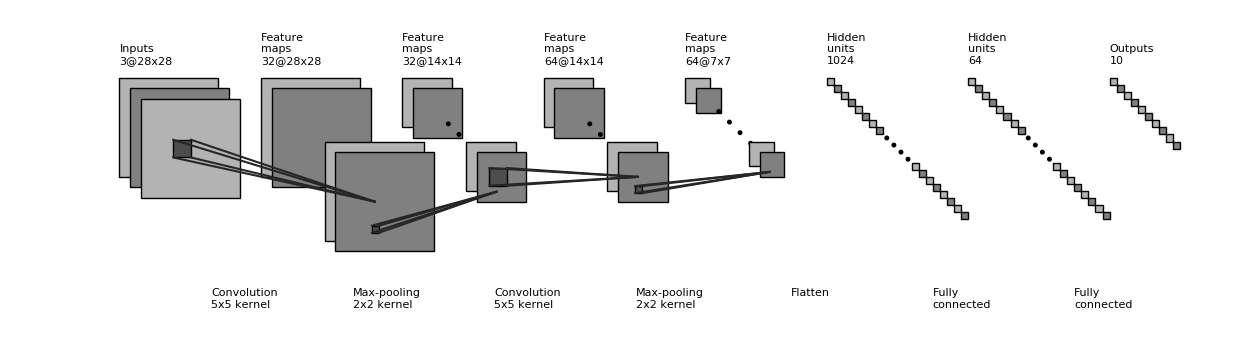

In [159]:
# 代码示例：

class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32,             # 卷积层神经元（卷积核）数目
            kernel_size=[5, 5],     # 感受野大小
            padding='same',         # padding策略（vaild 或 same）
            activation=tf.nn.relu   # 激活函数
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[5, 5],
            padding='same',
            activation=tf.nn.relu
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        self.dense1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        x = self.conv1(inputs)                  # [batch_size, 28, 28, 32]
        x = self.pool1(x)                       # [batch_size, 14, 14, 32]
        x = self.conv2(x)                       # [batch_size, 14, 14, 64]
        x = self.pool2(x)                       # [batch_size, 7, 7, 64]
        x = self.flatten(x)                     # [batch_size, 7 * 7 * 64]
        x = self.dense1(x)                      # [batch_size, 1024]
        x = self.dense2(x)                      # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

#### 关于
`self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))` 的效果展示如下：


In [3]:

class CNN1(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=3,             # 卷积层神经元（卷积核）数目
            kernel_size=[5, 5],     # 感受野大小
            padding='same',         # padding策略（vaild 或 same）
            activation=tf.nn.relu   # 激活函数
        )
        self.flatten = tf.keras.layers.Reshape(target_shape=(3 * 3 * 2,))

    def call(self, inputs):
        print(f'原始输入：{inputs.shape}\n {tf.squeeze(inputs)}')
        x1=self.conv1(inputs)
        print(f'卷积后：{x1.shape}\n {tf.squeeze(x1)}')
        x = self.flatten(inputs)            
        print(f'展平效果：{x.shape}\n {tf.squeeze(x)}')
        return x
    
model=CNN1()
input_shape = (1,3,3,2)
x = tf.random.normal(input_shape)
x
y = model(x)
y.shape

原始输入：(1, 3, 3, 2)
 [[[-0.31919134 -0.38661417]
  [-0.6172234   1.7298312 ]
  [-0.9443877  -0.2987698 ]]

 [[ 0.27963072 -0.48248804]
  [-1.3583528   1.1249568 ]
  [ 0.0410798  -0.264722  ]]

 [[ 0.6536508  -1.0681207 ]
  [-0.2753422  -0.5466368 ]
  [ 0.46405655 -1.327137  ]]]
卷积后：(1, 3, 3, 3)
 [[[0.         0.3908236  0.        ]
  [0.20128366 0.         0.7320632 ]
  [0.53569496 0.6374224  0.        ]]

 [[0.         0.83753616 0.        ]
  [0.         0.20004642 0.40682143]
  [0.57328475 0.18879157 0.19492717]]

 [[0.14627665 0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.07127558 0.        ]]]
展平效果：(1, 18)
 [-0.31919134 -0.38661417 -0.6172234   1.7298312  -0.9443877  -0.2987698
  0.27963072 -0.48248804 -1.3583528   1.1249568   0.0410798  -0.264722
  0.6536508  -1.0681207  -0.2753422  -0.5466368   0.46405655 -1.327137  ]


TensorShape([1, 18])

In [161]:
# 数据获取
import numpy as np

class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
# 定义超参数：
num_epochs=5
batch_size=50  # 每批次取50
learning_rate=0.001

# 实例化模型
model=CNN()
data_loader=MNISTLoader()
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)


# 然后迭代进行以下步骤：
    # 1从 DataLoader 中随机取一批训练数据；
num_batches=int(data_loader.num_train_data //batch_size*num_epochs)
for batch_index in range(num_batches):
    if batch_index>500: break
    X,y = data_loader.get_batch(batch_size)
    # 2. 将这批数据送入模型，计算出模型的预测值；
    with tf.GradientTape() as tape:
        y_pred = model(X)
        # 3.将模型预测值与真实值进行比较，计算损失函数（loss）。这里使用 tf.keras.losses 中的交叉熵函数作为损失函数；
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    # 4. 计算损失函数关于模型变量的导数；
    grads = tape.gradient(loss, model.variables)
    # 5. 将求出的导数值传入优化器，使用优化器的 apply_gradients 方法更新模型参数以最小化损失函数（优化器的详细使用方法见 前章 ）。    
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))



batch 0: loss 2.300414
batch 1: loss 2.359611
batch 2: loss 2.200969
batch 3: loss 2.118833
batch 4: loss 2.074027
batch 5: loss 1.850317
batch 6: loss 1.667630
batch 7: loss 1.362071
batch 8: loss 1.493575
batch 9: loss 1.136038
batch 10: loss 1.095038
batch 11: loss 0.853668
batch 12: loss 0.677746
batch 13: loss 0.737578
batch 14: loss 0.704715
batch 15: loss 0.675946
batch 16: loss 0.909206
batch 17: loss 0.613511
batch 18: loss 0.855696
batch 19: loss 0.495178
batch 20: loss 0.537999
batch 21: loss 1.066277
batch 22: loss 0.681320
batch 23: loss 0.536821
batch 24: loss 0.529009
batch 25: loss 0.733856
batch 26: loss 0.549487
batch 27: loss 0.549106
batch 28: loss 0.489631
batch 29: loss 0.629182
batch 30: loss 0.510124
batch 31: loss 0.436136
batch 32: loss 0.430816
batch 33: loss 0.450333
batch 34: loss 0.455005
batch 35: loss 0.230883
batch 36: loss 0.295768
batch 37: loss 0.465775
batch 38: loss 0.365057
batch 39: loss 0.168815
batch 40: loss 0.281068
batch 41: loss 0.169278
ba

batch 335: loss 0.149784
batch 336: loss 0.223976
batch 337: loss 0.205129
batch 338: loss 0.111697
batch 339: loss 0.036168
batch 340: loss 0.080862
batch 341: loss 0.071297
batch 342: loss 0.208595
batch 343: loss 0.058811
batch 344: loss 0.025529
batch 345: loss 0.053703
batch 346: loss 0.001794
batch 347: loss 0.044873
batch 348: loss 0.090233
batch 349: loss 0.025243
batch 350: loss 0.064908
batch 351: loss 0.016031
batch 352: loss 0.121562
batch 353: loss 0.040396
batch 354: loss 0.064569
batch 355: loss 0.033096
batch 356: loss 0.017143
batch 357: loss 0.008602
batch 358: loss 0.017484
batch 359: loss 0.039999
batch 360: loss 0.022530
batch 361: loss 0.107841
batch 362: loss 0.126587
batch 363: loss 0.034986
batch 364: loss 0.005454
batch 365: loss 0.047866
batch 366: loss 0.028994
batch 367: loss 0.067914
batch 368: loss 0.047358
batch 369: loss 0.020807
batch 370: loss 0.147573
batch 371: loss 0.139261
batch 372: loss 0.188271
batch 373: loss 0.075740
batch 374: loss 0.120328


In [162]:
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

test accuracy: 0.972000


## 使用预定义网络

tf.keras.applications 中有一些预定义好的经典卷积神经网络结构，

如 VGG16 、 VGG19 、 ResNet 、 MobileNet 等。我们可以直接调用这些经典的卷积神经网络结构（甚至载入预训练的参数），而无需手动定义网络结构。

通用的参数设置如下：

- input_shape ：输入张量的形状（不含第一维的 Batch），大多默认为 224 × 224 × 3 。一般而言，模型对输入张量的大小有下限，长和宽至少为 32 × 32 或 75 × 75 ；

- include_top ：在网络的最后是否包含全连接层，默认为 True ；

- weights ：预训练权值，默认为 'imagenet' ，即为当前模型载入在 ImageNet 数据集上预训练的权值。如需随机初始化变量可设为 None ；

- classes ：分类数，默认为 1000。修改该参数需要 include_top 参数为 True 且 weights 参数为 None 。


### 先看一下训练集
https://www.tensorflow.org/datasets/catalog/tf_flowers

3,670训练集

tf.Tensor(
[4 1 4 3 3 1 3 0 0 0 2 3 2 3 3 2 0 0 0 2 0 0 0 1 2 0 2 3 3 2 3 1 4 1 3 2 0
 0 0 2 3 2 0 0 2 2 4 0 2 2], shape=(50,), dtype=int64)
4


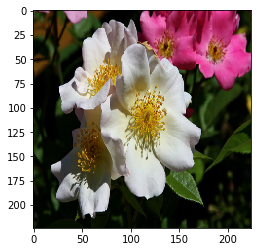

In [297]:
import tensorflow as tf
import tensorflow_datasets as tfds

num_epoch = 5
batch_size = 50
learning_rate = 0.001

dataset = tfds.load("tf_flowers", split=tfds.Split.TRAIN, as_supervised=True)
dataset = dataset.map(lambda img, label: (tf.image.resize(img, (224, 224)) / 255.0, label)).shuffle(1024).batch(batch_size)

for images, labels in dataset:
    print(labels)
    for i,v in enumerate(images):
        print(labels[i].numpy())
        pyplot.imshow(v)
        pyplot.show()
        break
    break


In [ ]:
model = tf.keras.applications.MobileNetV2(weights=None, classes=5)  # 随机初始化变量
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for e in range(num_epoch):
    for images, labels in dataset:
        with tf.GradientTape() as tape:
            labels_pred = model(images, training=True)  # 设置训练状态
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=labels, y_pred=labels_pred)
            loss = tf.reduce_mean(loss)
            print("loss %f" % loss.numpy())
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
    print(labels_pred)

### 关于图像尺寸调整
tf.image.resize

原始图像: 
 2 (28, 28, 1)


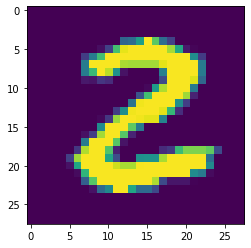

In [212]:

import matplotlib.pyplot as pyplot

train_data=MNISTLoader().train_data


i = 25
tmp = train_data[i]
print('原始图像:', '\n',train_label[i], tmp.shape)

pyplot.imshow(tmp[:,:,0])
pyplot.show()

调整后图像: 
 (224, 224, 1)


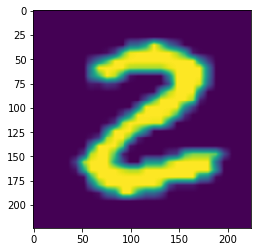

In [215]:
tmp1 = tf.image.resize(images=tmp, size=(224,224))/255.0
print('调整后图像:', '\n', tmp1.shape)
pyplot.imshow(tmp1[:,:,0])
pyplot.show()